In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import statistics
from sklearn.model_selection import train_test_split
import random

Helper Functions

In [6]:
def process_row(row):
    values_a = [float(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [7]:
def create_training_data(data : pd.DataFrame):
    score = np.zeros((1,14))
    scores = np.zeros((len(data), 14))
    i = 0

    data = data.sort_values(by=["start_time_min"])
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)
        for j in range(len(domains)):
            score[0, int(domains[j] - 1)] = domain_scores[j]
        # set score to the score list average
        scores[i] = score
        i += 1
    
    scores_df = pd.DataFrame(scores, columns=["domain %d score" % i for i in range(1, 15)])
    data.reset_index(drop=True, inplace=True)
    scores_df.reset_index(drop=True, inplace=True)
    data = pd.concat([data, scores_df], axis=1)
    return data

In [8]:
def filter_nonzero_rows(df, max_zeros):
    # Count number of zeros in each row
    zeros_count = (df == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [9]:
def missing(arr):
    return arr[0] == arr[1]

In [ ]:
def create_missing_indicator(data):
    """
    Creates a new DataFrame with each original column duplicated to indicate missing values
    (0 replaced by a random choice of 0 or 1) and its complement value.

    Parameters:
    - data (pd.DataFrame): The input DataFrame where 0s may indicate missing values.

    Returns:
    - pd.DataFrame: A DataFrame where each column from the original DataFrame is duplicated
                    with a missing indicator and a complement of the original non-zero values.
    """
    l, w = data.shape
    columns = []
    temp_data = np.zeros((l, w * 2))

    for col_index, column in enumerate(data.columns):
        for i in range(l):
            p = data.at[i, column]
            # update output array
            if p == 0:
                missing_ind = np.random.choice(2, 1)[0]
                temp_data[i, col_index * 2] = missing_ind
                temp_data[i, col_index * 2 + 1] = missing_ind
            else:
                temp_data[i, col_index * 2] = p  # score
                temp_data[i, col_index * 2 + 1] = 1 - p  # 1-score

        # Append new column names
        columns.append(f"{column}_score")
        columns.append(f"{column}_1_minus_score")

    # Create a new DataFrame from the modified array
    result_df = pd.DataFrame(temp_data, columns=columns)

    return result_df.copy()

Data processing

In [10]:
## read and process data
df = pd.read_csv("data/filtered_ds.csv")
df = df.sort_values(by=["patient_id", "start_time_min"])
df = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_18168/831601334.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("patient_id").apply(create_training_data).reset_index(drop=True)


In [11]:
## filter data to only sessions where the patient has all 14 domains (all ground truths)
model_data = df[["domain %d score" % i for i in range(1, 15)]]
model_data = filter_nonzero_rows(model_data, 0)
model_data = create_missing_indicator(model_data)
ground_truth = copy.deepcopy(model_data)

Training process

In [12]:
## define model
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        hidden1 = 150
        hidden2 = 25
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 2, hidden1),
            torch.nn.Sigmoid(),
            # torch.nn.Linear(hidden1, hidden2),
            # torch.nn.Sigmoid(),
            torch.nn.Linear(hidden1, n_domains * 2),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [13]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 28 ## hardcoded

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for i in range(len(x_train)):
            session = x_train[i]
            # Output of Autoencoder
            session_rs = session.reshape(-1, w)
            session_t = torch.from_numpy(session_rs).float()
            reconstructed = model(session_t)
            
            # # handle missing value
            missing_exists = False
            missing_domains = []
            for domain in range(w):
                if missing(session[domain*2:domain*2+2]):
                    missing_exists = True
                    missing_domains.append(domain)
                
            if missing_exists:
                session_dc = copy.deepcopy(y_train[i])
                for d in missing_domains:
                    target = reconstructed.detach().numpy()[0][d*2:d*2+2]
                    session_dc[d*2:d*2+2] = target
                    session_dc = session_dc.reshape(-1, w * 2)
                    session_t = torch.from_numpy(session_dc).float()


            # Calculating the loss function
            loss = loss_function(reconstructed, session_t)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        outputs.append((epochs, session_t, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            for k in range(len(x_val)):
                val = x_val[k]
                val_rs = val.reshape(-1, w)
                val_t = torch.from_numpy(val_rs)
                val_t = val_t.clone().detach().type(torch.float32)
                answer = model(val_t)
                val_loss = loss_function(answer, torch.tensor(y_val[k]).type(torch.float32))
                val_epoch_loss.append(val_loss.item())
        val_losses.append(statistics.mean(val_epoch_loss))
    return losses, val_losses, outputs, model

In [14]:
## take in two data arrays and return predictions for both in a tuple
def get_predictions(training, validation, model):
    model.eval()
    with torch.no_grad():
        return model(torch.tensor(training).type(torch.float32)), model(torch.tensor(validation).type(torch.float32))

In [15]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='Mean', color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='Standard Deviation')
    
    plt.title('Mean and Standard Deviation Plot of %s' %setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

In [16]:
## train mutliple run function
def multi_run(training_data, target_data, num_runs=3):
    losses_2d = []
    val_losses_2d = []

    for i in range(num_runs):
        model = AE()
        epochs = 10
        lr = 0.005

        # Validation using MSE Loss function
        loss_function = torch.nn.MSELoss()
        
        # Using an Adam Optimizer
        optimizer = torch.optim.Adam(model.parameters(),
                                    lr = lr)
        
        x_train, x_val, y_train, y_val = train_test_split(training_data, target_data, test_size=0.20)
        with torch.no_grad():
            initial_pred_train = model(torch.tensor(x_train).type(torch.float32))
            zero_loss = loss_function(torch.tensor(initial_pred_train).type(torch.float32), torch.tensor(y_train).type(torch.float32))

            initial_pred_val = model(torch.tensor(x_val).type(torch.float32))
            zero_loss_val = loss_function(torch.tensor(initial_pred_val).type(torch.float32), torch.tensor(y_val).type(torch.float32))
        
        losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
        losses = [zero_loss.item()] + losses
        val_losses = [zero_loss_val.item()] + val_losses
        
        losses_2d.append(losses)
        val_losses_2d.append(val_losses)
    
    ## use the last trained model to get predictions
    predictions_train, predictions_val = get_predictions(x_train, x_val, model)

    return x_train, x_val, y_train, y_val, losses_2d, val_losses_2d, predictions_train, predictions_val

Individual domains

In [17]:
## run
def train_domain(target_domain : int, model_data=model_data, ground_truth=ground_truth):
    target_domain_name = "domain %d score" % target_domain
    target = copy.deepcopy(ground_truth[target_domain_name]).to_numpy().reshape(-1, 1)
    train_data = model_data.drop([target_domain_name], axis=1).to_numpy()
    # return results from training a model for multiple runs
    return multi_run(train_data, target)

Assign level groups

In [48]:
def find_level(points, point):
    for i in range(len(points) - 1, -1, -1):
        if point <= points[i]:
            return len(points) - i
    print("error")

In [49]:
## separate sessions into x number of levels based on the 13 domains
def level_assignment(data, num_levels=5, mode=""):
    assert(mode != "")
    lvls = []
    # get the average
    avg = np.mean(data, axis=1)
    # find level separation points
    if mode == "fixed":
        high = avg.max()
        low = avg.min()
        seps = [high - (high - low) / num_levels * i for i in range(num_levels)]
    elif mode == "percentile":
        seps = [np.percentile(avg, 100 / num_levels * (num_levels - i)) for i in range(num_levels)]
    else:
        raise AssertionError("mode not implemented")
    for p in avg:
        lvls.append(find_level(seps, p))
    return lvls

In [50]:
def results_domain(target_domain : int, model_data=model_data, ground_truth=ground_truth):
    # run training functions to get the results
    x_train, x_val, y_train, y_val, training_loss, validation_loss, predictions_train, predictions_val = train_domain(target_domain, model_data=model_data, ground_truth=ground_truth)
    # create numpy array with training data (not including target) but maintain train val split order
    original = np.hstack((np.vstack((x_train, x_val)), np.vstack((y_train, y_val))))
    # find level for each session (row)
    levels_fixed = np.vstack((np.array(level_assignment(x_train, mode="fixed")).reshape(-1, 1), np.array(level_assignment(x_val, mode="fixed")).reshape(-1, 1)))
    levels_percentile = np.vstack((np.array(level_assignment(x_train, mode="percentile")).reshape(-1, 1), np.array(level_assignment(x_val, mode="percentile")).reshape(-1, 1)))
    # work with predictions
    predictions = np.vstack((predictions_train.numpy(), predictions_val.numpy()))
    # hstack everything to create a big numpy array to convert into dataframe
    data_with_levels = np.hstack((original, levels_fixed))
    data_with_levels = np.hstack((data_with_levels, levels_percentile))
    data_with_levels = np.hstack((data_with_levels, predictions))

    # create dataframe
    column_names = ["non-target domain score %d" % i for i in range(1, 14)] + ["target domain", "fixed level", "percentile level", "predicted score"]
    df_with_levels = pd.DataFrame(data_with_levels, columns=column_names)
    return df_with_levels, training_loss, validation_loss

Visualization

In [51]:
model_data.shape

(136131, 14)

In [94]:
domain_n = 14

In [95]:
results, traing_loss, val_loss = results_domain(domain_n, model_data=model_data, ground_truth=ground_truth)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_18168/1264182726.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_loss = loss_function(torch.tensor(initial_pred_train).type(torch.float32), torch.tensor(y_train).type(torch.float32))
/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_18168/1264182726.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_loss_val = loss_function(torch.tensor(initial_pred_val).type(torch.float32), torch.tensor(y_val).type(torch.float32))
/opt/homebrew/anaconda3/envs/ct/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1,

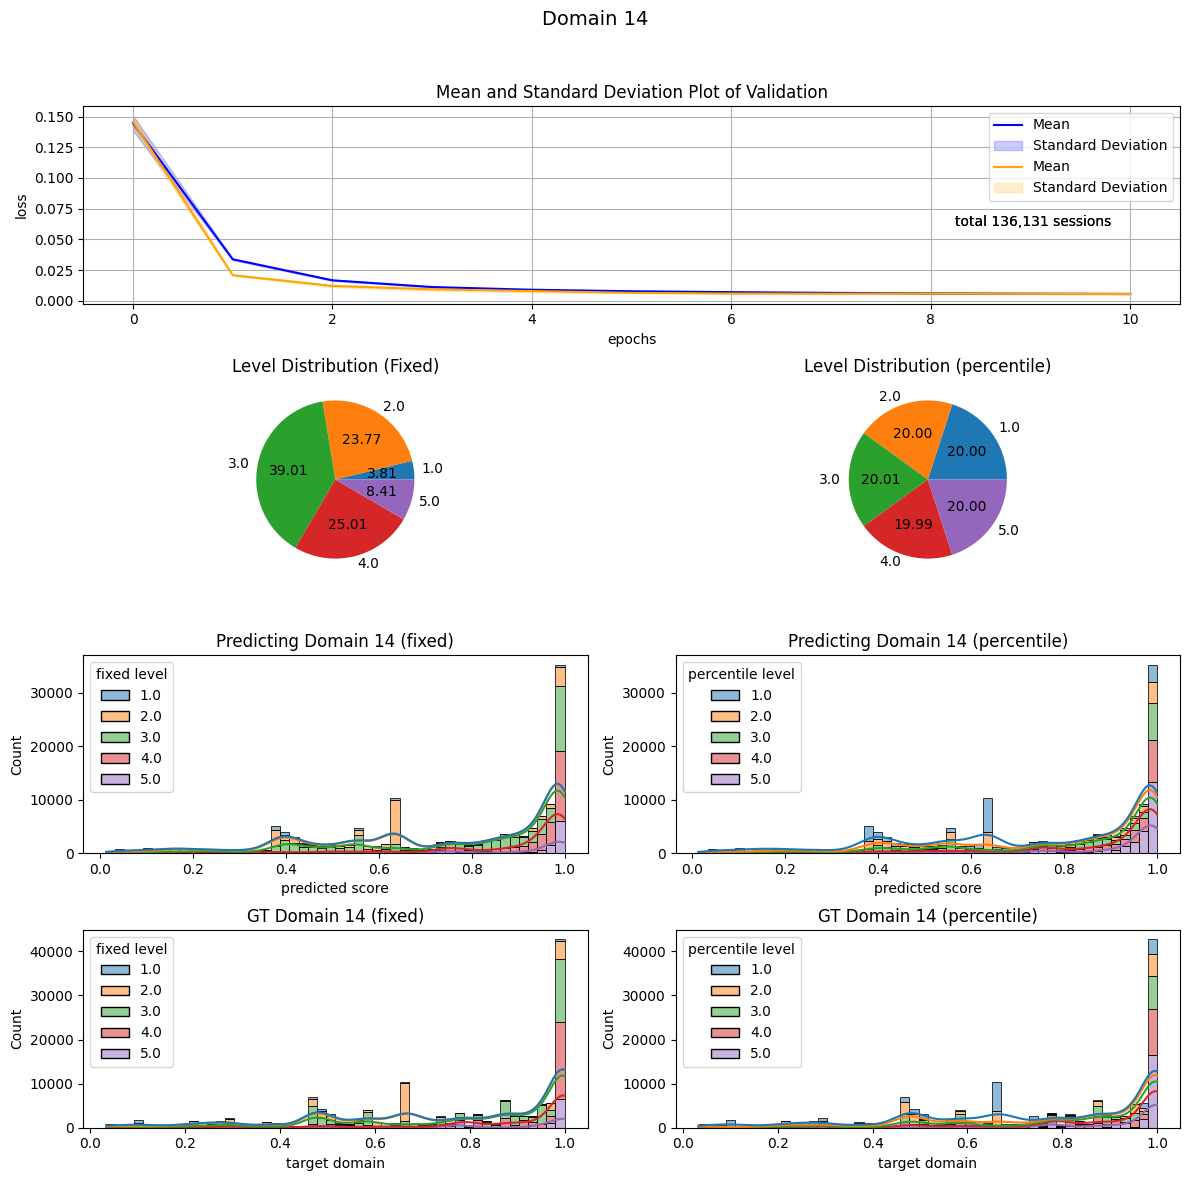

Bad pipe message: %s [b'm']
Bad pipe message: %s [b'{\xf3\xb6\xc5d\xff\x9d\xd3g\x905\x11e\xb4\xe7\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf']
Bad pipe message: %s [b'\x85\x95\xdc\x90\x97=\xc6\xb4\xf7Z\x19\xe7$r\x92Kyo\x00\x000\x00A\x00B\x00C\x00D\x00E\x00F\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3']
Bad pipe message: %s [b'\xbc\xd4\

In [96]:
fig = plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plot_mean_and_std(traing_loss, "blue", "Training")
plot_mean_and_std(val_loss, "orange", "Validation")

plt.subplot(4, 2, 3)
results.groupby("fixed level").size().plot.pie(autopct="%.2f")
plt.title("Level Distribution (Fixed)")
plt.figtext(.8, .8, "total 136,131 sessions")

plt.subplot(4, 2, 4)
results.groupby("percentile level").size().plot.pie(autopct="%.2f")
plt.title("Level Distribution (percentile)")
plt.figtext(.8, .8, "total 136,131 sessions")

plt.subplot(4, 2, 5)
plt.title("Predicting Domain %d (fixed)" % domain_n)
sns.histplot(data=results, x="predicted score", bins=50, kde=True, hue="fixed level", palette = "tab10", multiple="stack")

plt.subplot(4, 2, 6)
plt.title("Predicting Domain %d (percentile)" % domain_n)
sns.histplot(data=results, x="predicted score", bins=50, kde=True, hue="percentile level", palette = "tab10", multiple="stack")

plt.subplot(4, 2, 7)
plt.title("GT Domain %d (fixed)" % domain_n)
sns.histplot(data=results, x="target domain", bins=50, kde=True, hue="fixed level", palette = "tab10", multiple="stack")

plt.subplot(4, 2, 8)
plt.title("GT Domain %d (percentile)" % domain_n)
sns.histplot(data=results, x="target domain", bins=50, kde=True, hue="percentile level", palette = "tab10", multiple="stack")

fig.suptitle("Domain %d" % domain_n, size=14)
fig.tight_layout()
fig.subplots_adjust(top=0.90)